In [98]:
import os
import pandas as pd
from datasets import Dataset,DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import numpy as np, matplotlib.pyplot as plt
from numpy.random import normal,seed,uniform
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_california_housing
from transformers import TrainingArguments,Trainer
import datasets

In [17]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [11]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [102]:
creds='{"username":"atikarahmanpaddo","key":"XXX"}'

In [19]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [24]:
path = Path('us-patent-phrase-to-phrase-matching')

In [26]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 682k/682k [00:00<00:00, 21.4MB/s]

In [27]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

In [28]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [32]:
df = pd.read_csv(path/'train.csv')

In [33]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [34]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [35]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [36]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [38]:
ds = Dataset.from_pandas(df)

In [39]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [41]:
model_nm = 'microsoft/deberta-v3-small'

In [43]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/jupyter-apaddo/.local/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
tokz.tokenize("Hello folks, I am Atika from IUPUI!")

['▁Hello', '▁folks', ',', '▁I', '▁am', '▁At', 'ika', '▁from', '▁IUPUI', '!']

# Uncommon words will be splitted

In [49]:
tokz.tokenize("A water lily is a hydrohfjasfhsiurgdsiu flower from south asia.")

['▁A',
 '▁water',
 '▁lily',
 '▁is',
 '▁a',
 '▁hydro',
 'hf',
 'jas',
 'fh',
 'si',
 'urg',
 'd',
 's',
 'iu',
 '▁flower',
 '▁from',
 '▁south',
 '▁asia',
 '.']

In [51]:
def tok_func(x): return tokz(x["input"])

In [52]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [53]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [55]:
tokz.vocab['▁are']

281

In [56]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [57]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [58]:
def f(x): return -3*x**2 + 2*x + 20

In [61]:
def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

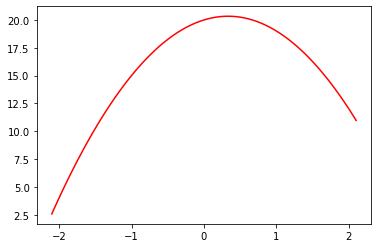

In [62]:
plot_function(f)

In [64]:
np.random.seed(42)

In [66]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

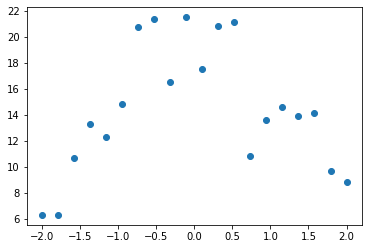

In [67]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [69]:
def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

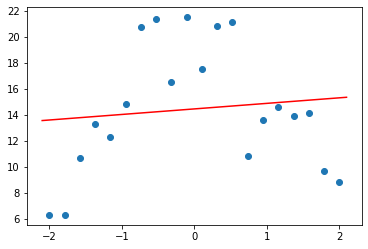

In [70]:
plot_poly(1)

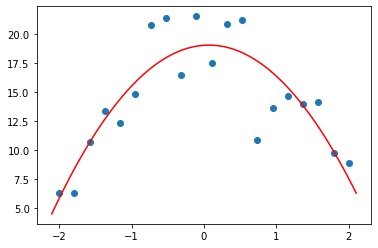

In [71]:
plot_poly(2)

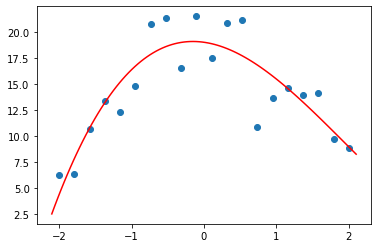

In [72]:
plot_poly(3)

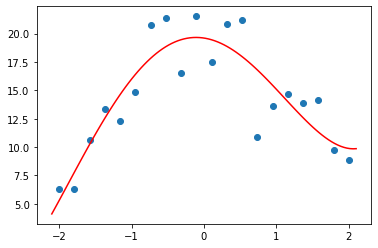

In [73]:
plot_poly(4)

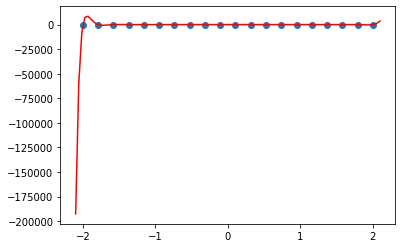

In [74]:
plot_poly(20)

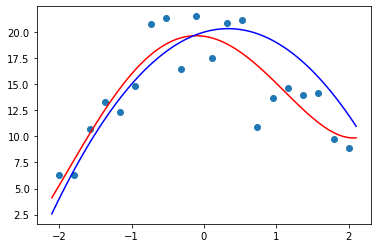

In [76]:
plot_poly(4)
plot_function(f, color='b')

In [77]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [78]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [80]:
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [81]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [82]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [83]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906005

In [84]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

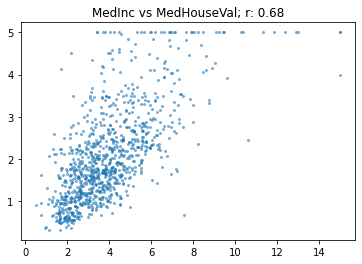

In [85]:
show_corr(housing, 'MedInc', 'MedHouseVal')

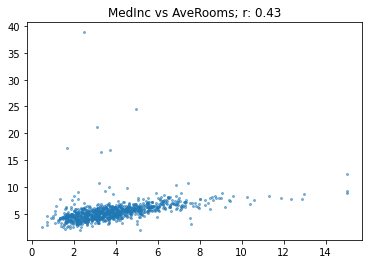

In [86]:
show_corr(housing, 'MedInc', 'AveRooms')

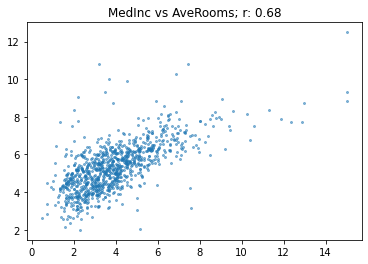

In [87]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

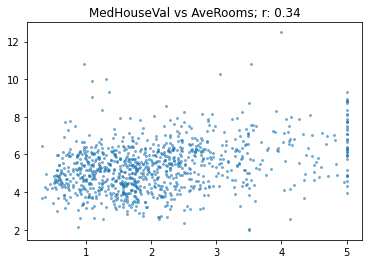

In [88]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

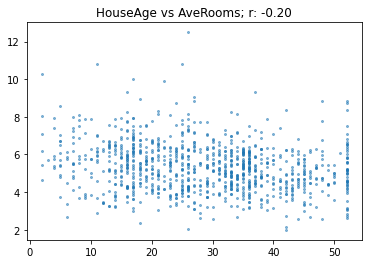

In [89]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [90]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

# To train a mode, let's use transformers

In [94]:
bs = 128
epochs = 4
lr = 8e-5

In [95]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [96]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [97]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, id, input, context, target. If anchor, id, input, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-apaddo/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/jupyter-apaddo/.local/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEV

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028116,0.795437
2,No log,0.023894,0.820111
3,No log,0.022429,0.826423
4,No log,0.022770,0.829264


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, id, input, context, target. If anchor, id, input, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, id, input, context, target. If anchor, id, input, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, id, input, context, target. If anchor, id

TrainOutput(global_step=428, training_loss=0.025134786267146887, metrics={'train_runtime': 284.8527, 'train_samples_per_second': 384.114, 'train_steps_per_second': 1.503, 'total_flos': 747252572998440.0, 'train_loss': 0.025134786267146887, 'epoch': 4.0})

In [99]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, id, input, context, target. If anchor, id, input, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 512


array([[ 0.5 ],
       [ 0.69],
       [ 0.5 ],
       [ 0.3 ],
       [-0.04],
       [ 0.56],
       [ 0.46],
       [ 0.01],
       [ 0.32],
       [ 1.14],
       [ 0.24],
       [ 0.23],
       [ 0.75],
       [ 0.8 ],
       [ 0.76],
       [ 0.34],
       [ 0.31],
       [-0.02],
       [ 0.71],
       [ 0.29],
       [ 0.44],
       [ 0.21],
       [ 0.09],
       [ 0.23],
       [ 0.59],
       [-0.05],
       [-0.07],
       [-0.04],
       [-0.05],
       [ 0.61],
       [ 0.31],
       [ 0.03],
       [ 0.69],
       [ 0.5 ],
       [ 0.46],
       [ 0.19]])

In [100]:
preds = np.clip(preds, 0, 1)
preds

array([[0.5 ],
       [0.69],
       [0.5 ],
       [0.3 ],
       [0.  ],
       [0.56],
       [0.46],
       [0.01],
       [0.32],
       [1.  ],
       [0.24],
       [0.23],
       [0.75],
       [0.8 ],
       [0.76],
       [0.34],
       [0.31],
       [0.  ],
       [0.71],
       [0.29],
       [0.44],
       [0.21],
       [0.09],
       [0.23],
       [0.59],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.61],
       [0.31],
       [0.03],
       [0.69],
       [0.5 ],
       [0.46],
       [0.19]])

In [101]:
submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

854